# Part 1: Extend a 2D CNN to 3D

Last week, we trained a 2D convolutional neural network (CNN) on slices of a subset of the ACDC dataset.

This week, we will train a **3D** CNN on the **entire** (3D) images of the **whole** ACDC dataset.


You can reuse and modify the code from last week to solve this week's task. Specifically, you'll need to:
1. [**Data**]. Make a train-validation-test split that uses all the training set.
2. [**Model**]. Extend the model to 3D (*hint: read MONAI's documentation if needed*).
3. [**Training**]. Since we'll train on the whole 3D images, you don't need to extract slices from the images.
4. [**Inference**]. *Hint: Remember that now, the model produces 3D images directly*
5. [**Metrics**]. In addition to Dice coefficient, use other metrics that you think might be relevant now. You can use the metrics from MONAI or from medpy.metrics (the latter is probably easier).

In [57]:
import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
from monai.data import DataLoader, Dataset
from pathlib import Path
from monai.transforms.utils import allow_missing_keys_mode
from monai.transforms import BatchInverseTransform
from monai.networks.nets import DynUNet
import nibabel as nib
from tqdm import tqdm
import medpy.metric as metric

## 1.1 Data: Train-validation-test splits

> ---
> **Task:** Make a train-validation-test split (70-10-20) that uses **all** the training set (100 patients).
>
> **Important remark**: the parameters `first_id` and `last_id` of `getPatientData` function look at the patients id, which, as you can see in the `DATA_PATH` folder, starts with "patient001". In other words, if you want to create a dataset with the images from the 100 patients, you need to call the function in the following way: `getPatientData(dataset_path=..., first_id=1, last_id=100)`.
> 
> ---
> 


In [ ]:
def get_patient_data(dataset_path: Path, first_id: int, last_id: int):
    dataset = []
    for i in range(first_id, last_id+1):
        patient_id = f'patient{str(i).zfill(3)}'
        tmp_path = dataset_path / patient_id
        for path_frame in tmp_path.glob("*frame[0-9][0-9].nii.gz"):
            dataset.append({'image': str(path_frame),
                            'label': str(path_frame).replace(".nii.gz", "_gt.nii.gz"),
                            'id': path_frame.name.split(".")[0]})
    return dataset

DATA_PATH = "data/ACDC17"

# 1. Data. Make a 70-10-20% train-validation-test split here
train_files = get_patient_data(dataset_path=Path(DATA_PATH),
                            first_id=1, last_id=70)
val_files = get_patient_data(dataset_path=Path(DATA_PATH),
                            first_id=71, last_id=80)  
test_files = get_patient_data(dataset_path=Path(DATA_PATH),
                            first_id=81, last_id=100)
train_files[0]

In [ ]:
# Verifying that your train-validation-test split is using the whole dataset
messages = []
if len(train_files) == 70*2:
    messages.append("✅ Training set size")
else:
    messages.append("❌ The training set must consist of the images of 70 patients (140 images in total)")
    
if len(val_files) == 10*2:
    messages.append("✅ Validation set size")
else:
    messages.append("❌ The validation set must consist of the images of 10 patients (20 images in total)")
    
if len(test_files) == 20*2:
    messages.append("✅ Test set size")
else:
    messages.append("❌ The test set must consist of the images of 20 patients (40 images in total)")

allimages = set()
for im in train_files + val_files + test_files:
    allimages.add(im['image'])
if len(allimages) != 100*2:
    messages.append("❌ There should be 200 *unique* images in the train, validation and test sets")

for m in messages:
    print(m)

## 1.2 Model

> ---
> **Task:** Extend last week's model to 3D. Check MONAI's documentation for this: https://docs.monai.io/en/stable/networks.html#nets
> 
> ---
> 

In [60]:
# 2. Model. Extend the model to 3D 
model = DynUNet(
    spatial_dims = 3,
    in_channels = 1, 
    out_channels = 4,
    kernel_size = [3, 3, 3, 3, 3, 3],
    strides = [1, 2, 2, 2, 2, 2], 
    upsample_kernel_size = [2, 2, 2, 2, 2]
).cuda()

In [61]:
# Verifying that your model is 3D
err = False
for name, W in model.named_parameters():
    if 'conv.weight' in name:
        if len(W.shape) != 5:
            err = True
            break
if err:
    print("❌ Your model doesn't seem to be 3D")
else:
    print("✅ Your model seem to be 3D")

✅ Your model seem to be 3D


## 1.3 Training
> ---
> **Task:** Gather the relevant preprocessing and data-augmentation transforms for training your 3D CNN model on 3D images.
> 
> ---
> 

In [62]:
allFiles = train_files + val_files + test_files

# 1) Create an empty list that will contain the voxel resolutions of all the images

# 2) Iterate over all paths in trainFiles, valFiles and testFiles
# 2.1) Open the images, gather their voxel size/resolution, put it in the list
voxelDims = [nib.load(file['image']).header.get_zooms() for file in allFiles]
voxelDims = np.array(voxelDims)

# 3) Find the maximum and minimum voxel resolution across all images in each dimension
#    (i.e., maximum and minimum voxel size in the first dimension, second dimension,
#     and third dimension, 6 numbers in total)
smallestVoxelDims = np.min(voxelDims, axis=0)
largestVoxelDims = np.max(voxelDims, axis=0)

# Follow the same steps for the image size
imageDims = [nib.load(file['image']).header.get_data_shape() for file in allFiles]
imageDims = np.array(imageDims)

# 3) Find the maximum and minimum voxel resolution across all images in each dimension
#    (i.e., maximum and minimum voxel size in the first dimension, second dimension,
#     and third dimension, 6 numbers in total)
smallestImDims = np.min(imageDims, axis=0)
largestImDims = np.max(imageDims, axis=0)

print("smallestVoxelDims", smallestVoxelDims)
print("largestVoxelDims", largestVoxelDims)
print("smallestImDims", smallestImDims)
print("largestImDims", largestImDims)

smallestVoxelDims [0.703125 0.703125 5.      ]
largestVoxelDims [ 1.91964  1.91964 10.     ]
smallestImDims [154 154   6]
largestImDims [428 512  18]


In [67]:
# 3. Data and Training. Put all the data-augmentation transforms here
#train_transforms = monai.transforms.Compose([
#    FILLTHIS
#])

#val_transforms = monai.transforms.Compose([
#    FILLTHIS
#])

newVoxelDims = np.median(voxelDims, axis=0)
spatialSize = 320, 320, 32

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=newVoxelDims, mode=["bilinear", "nearest"]),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=spatialSize),
    #monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[-1, -1, 1]),
    #monai.transforms.SqueezeDimd(keys=['image', 'label'], dim=-1),
    ## TODO: Add more Data Augmentation functions here
    #monai.transforms.RandRotated(keys=['image', 'label'], range_z = 180, prob = 0.5, mode='nearest'),
    #monai.transforms.RandGaussianSmoothd(keys=['image'], sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5), sigma_z=(0.25, 1.5), approx='erf', prob=0.5),
    #monai.transforms.RandGaussianNoised(keys=['image'], prob=0.5, mean=0.0, std=0.5),

    monai.transforms.AsDiscreted(keys=['label'], to_onehot=4) # Convert "label" to onehot encoded.
])

val_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=newVoxelDims, mode=["bilinear", "nearest"]),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=spatialSize),
])

AttributeError: 'Compose' object has no attribute 'cuda'

In [64]:
# Verifying that you're training on 3D images
dummy_dataset = Dataset(data=train_files, transform=train_transforms)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False)

err1, err2 = False, False
num_slices = set()
for dummy_data in dummy_loader:
    if len(dummy_data['image'].shape) != 5:
        err1 = True
        
    num_slices.add(dummy_data['image'].shape[-1])
    if len(num_slices) != 1:
        err2 = True

if err1:
    print("❌ Your dataloader doesn't give you 3D images.")
else:
    print("✅ Your dataloader gives you 3D images")

if err2:
    print("❌ Your images have different number of slices, so, they won't fit into a single mini-batch. Maybe you need to use ResizeWithPadOrCropd?")
else:
    print("✅ Your images have the same number of slices.")

✅ Your dataloader gives you 3D images
✅ Your images have the same number of slices.


## 1.4 Verifying your model

At this point, you should have:
* [**Data**] The dataset split into train-validation-set.
* [**Data,Training**] The data-augmentation transforms, including the "preprocessing" transforms.
* [**Training**] The data loaders.
* [**Model**] A 3D model to train.

Let's try to do inference in a few images. Does it work?

In [66]:
# 2. Model. Now, use your model to do inference in a few images
for i, dummy_data in enumerate(dummy_loader):
    inputs = dummy_data['image']
    print(inputs.shape)
    pred = model(inputs)
    if i > 5:
        break

torch.Size([1, 1, 320, 320, 32])


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

If you used the same architecture of the model that you trained last week, **you got probably an error** (if everything went fine, congrats!).

This error is likely caused due to the small and incompatible number of features in the last dimension. Remember from last week that it is important to find an appropriate image size to train the network:

In [ ]:
torch.cuda.is_available()

In [ ]:
# This will work
inputs = torch.rand((1, 1, 128, 128, 32)).cuda()
pred = model(inputs).cuda()
print(pred.shape)

# This will not work
# inputs = torch.rand((1, 1, 320, 320, 11))
# pred = model(inputs)
# print(pred.shape)

Remember that the encoder of UNet-like architectures downsamples the input images multiple times. If, e.g., our feature maps have a size of 320x320x11, after downsampling them (with strides=2) once, the feature maps will be 160x160xF. What would F be: Five or Six? It depends on the configuration of the network. This detail might not be too important in the encoder, but it is an important consideration in the decoder when trying to concatenate the feature maps from the encoder and decoder. Chances are that your code raised a RuntimeError when attempting to torch.cat in the skip layers.

[<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="700px">](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

> ---
> **Task:**
> 
> Find:
> 1. A network configuration,
> 2. An image size (for the ResizeWithPadOrCropd transform) and
> 3. A batch size
> 
> that are **compatible**, and that **fit** in the GPU.
>
> **Note**: Regarding the image size for ResizeWithPadOrCrop, last week we only cared about finding an appropriate HxW and did not care about the Depth dimension because we were training on slices. Now, you must find HxWxD.
> 
> ---

In [ ]:
a = 320
inferer = monai.inferers.SlidingWindowInferer(roi_size=(a, a,-1), sw_batch_size=1)
inferer(torch.randn(1,1,a,a,32).cuda(), model).shape

In [ ]:
# a = 320
for a in [100 + 2*i for i in range(400)]:
    try:
        inferer = monai.inferers.SliceInferer(roi_size=(a, a), sw_batch_size=1, spatial_dim=2)
        inferer(torch.randn(1,1,a,a,28).cuda(), model).shape
        print(a)
    except:
        pass
    # print("e")

In [ ]:
# Hyper-parameters (next three lines) #
BATCH_SIZE = 1
NUM_EPOCHS = 1
EVAL_EVERY = 1

train_dataset = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# More design decisions (model, loss, optimizer) #

loss_fn = monai.losses.DiceLoss(softmax=True, to_onehot_y=False) # Apply "softmax" to the output of the network and don't convert to onehot because this is done already by the transforms.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

# inferer = monai.inferers.SliceInferer(roi_size=[320, 320], cval=-1, sw_batch_size=1)
# inferer = monai.inferers.SimpleInferer()#monai.inferers.SliceInferer(roi_size=(320, 320), sw_batch_size=1, cval=-1, progress=True)
inferer = monai.inferers.SlidingWindowInferer(roi_size=(320, 320, -1), sw_batch_size=1)


all_losses = []
all_dices = []
all_hd95 = []

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}')

    model.train()
    epoch_loss = 0
    step = 0
    for tr_data in train_loader:
        inputs = tr_data['image'].cuda()
        targets = tr_data['label'].cuda()

        # Forward -> Backward -> Step
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach()
        step += 1
        
    # Log and store average epoch loss
    epoch_loss = epoch_loss.item() / step
    all_losses.append(epoch_loss)
    print(f'Mean loss: {epoch_loss}')

    if epoch % EVAL_EVERY == 0:
        model.eval()
        with torch.no_grad():  # Do not need gradients for this part
            for val_data in val_loader:
                inputs = val_data['image'].cuda()
                targets = val_data['label'].cuda()

                # Gets the prediction in the entire 3D image. Shape = BCHWD
                # inputs = inputs.permute(0, 1, 4, 2, 3) # changed                
                prediction = inferer(inputs=inputs, network=model)

                # Inverses the transformations, i.e., it:
                # - Unpads/Uncrops the image
                # - Resamples back to the original voxel resolution
                batch_inverter = BatchInverseTransform(val_transforms, val_loader)
                with allow_missing_keys_mode(val_transforms):
                    inversed_prediction = batch_inverter({"label": prediction}) # Shape: inversed_prediction[B]['label'].shape = CHWD
                    inversed_targets = batch_inverter({"label": targets}) # Shape: inversed_targets[B]['label'].shape = 1HWD

                # Applying argmax on that prediction
                inversed_prediction = [monai.transforms.AsDiscrete(argmax=True)(pred['label']) for pred in inversed_prediction]

                val_dices = []
                val_hd95 = []
                # Compute the dice coefficients
                for b in range(prediction.shape[0]):
                    dices_tmp = []
                    hd95_tmp = []
                    for c in range(1, prediction.shape[1]): # Iterate over each class (except the first one, that corresponds to the background)
                        dices_tmp.append( metric.dc( 1*(inversed_prediction[b].cpu().detach().numpy()==c),
                                                   1*(inversed_targets[b]['label'].cpu().detach().numpy()==c) ) )
                        # hd95_tmp.append(metric.hd95(prediction[b][c], targets[b][c], voxelspacing=newVoxelDims))
                    val_dices.append(dices_tmp)
                    val_hd95.append(metric.hd95(prediction.argmax(dim=1).squeeze(), targets.squeeze(), voxelspacing=newVoxelDims))

        # Log and store the average Dice coefficient across images; one value per class
        all_dices.append(np.mean(val_dices, axis=0))
        all_hd95.append(np.mean(val_hd95, axis=0))
        print(f'Dice coefficients: {all_dices[-1]}')
        print(f'HD distances: {all_hd95[-1]}')

> ---
> **Task:**
> 
> Similarly to last week, visualize 1) the training loss, 2) the validation dice coefficient, and 3) the validation of the other metric of your choice.
>
> ---

In [68]:
print(prediction.shape, prediction.argmax(dim=1).squeeze().shape, targets.shape, targets.squeeze().shape)

NameError: name 'prediction' is not defined

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

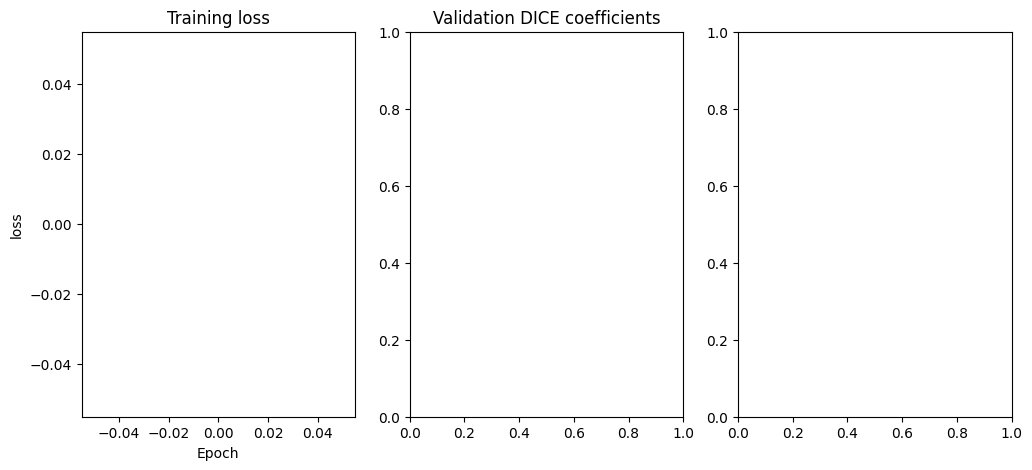

In [69]:
# Code for the task here
# plt.plot(all_losses)
ad = np.array(all_dices)
ah = np.array(all_hd95)

fig, axs = plt.subplots(1,3, figsize = (12,5))
axs[0].set_title("Training loss")
axs[0].plot(all_losses)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("loss")

axs[1].set_title("Validation DICE coefficients")
axs[1].plot(ad[:,0], label = "Left Ventricle")
axs[1].plot(ad[:,1], label = "Myocardium")
axs[1].plot(ad[:,2], label = "Right Ventricle")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("DICE coefficient")
plt.legend()

axs[2].set_title("Validation 95th percentile of the Hausdorff Distance")
axs[2].plot(ah)#, label = "Left Ventricle")
# axs[2].plot(ah[:,1], label = "Myocardium")
# axs[2].plot(ah[:,2], label = "Right Ventricle")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Distance")
# plt.legend()
plt.show()

## 1.6 Inference in the test set

> ---
> **Task**: Compute the predictions of the test set images.
>
> **Important remark**: Fill the list "test_dices", which is a list of lists. E.g., test_dices = [ [id1, dice1, dice2, dice3], [id2, dice1, dice2, dice3], ...]. Here, idN is the name of the file (e.g., patient019_frame12) that you get from `test_data['id']`, and each dice corresponds to the Dice coefficient in each class except in 'class 0' (background).
>
> ---

In [70]:
from tqdm import trange, tqdm

In [71]:
test_dices = []

test_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=newVoxelDims, mode=["bilinear", "nearest"]),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=spatialSize),
])

inferer = monai.inferers.SlidingWindowInferer(roi_size=(320, 320, -1), sw_batch_size=1)

test_dataset = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


model = model.cpu()
test_dices = []
for test_data in tqdm(test_loader):
    inputs = test_data['image']#.cuda()
    targets = test_data['label']#.cuda()
    ids = test_data['id']

    prediction = inferer(inputs=inputs, network=model)
    
    batch_inverter = BatchInverseTransform(test_transforms, test_loader)
    with allow_missing_keys_mode(test_transforms):
        inversed_prediction = batch_inverter({"label": prediction}) # Shape: inversed_prediction[B]['label'].shape = CHWD
        inversed_targets = batch_inverter({"label": targets}) # Shape: inversed_targets[B]['label'].shape = 1HWD

    # Applying argmax on that prediction
    inversed_prediction = [monai.transforms.AsDiscrete(argmax=True)(pred['label']) for pred in inversed_prediction]

    # Compute the dice coefficients
    for b in range(prediction.shape[0]):
        print(" --- ", ids)
        dices = [ids[0]]
        for c in range(1, prediction.shape[1]): # Iterate over each class (except the first one, that corresponds to the background)
            dice = metric.dc( 1*(inversed_prediction[b].cpu().detach().numpy()==c), 1*(inversed_targets[b]['label'].cpu().detach().numpy()==c))
            dices.append(dice)
        print(dices)
        test_dices.append(dices)

# Checking that your "test_dices" has the right format.
assert len(test_dices) == 40
for line in test_dices:
    assert len(line) == 4

for frameid, dice1, dice2, dice3 in test_dices:
    print(f"Frame ID: {frameid}. Dice coeff. (Class 1): {dice1}. Dice coeff. (Class 2): {dice2}. Dice coeff. (Class 3): {dice3}")

avg_dice = np.mean([[d1, d2, d3] for _, d1, d2, d3 in test_dices])
print(f"Final average dice: {avg_dice}") # This should be one single number. It will be later used to compare which model is better

NameError: name 'testFiles' is not defined

## 1.7 Misc: Saving and loading PyTorch models

In Pytorch we are typically interested in saving the trained models to, later, use it for inference. Here, we say "saving models" in a loose way since, in practice, we don't save the model; we save the **parameters** of the model. Saving these parameters can be done in the following way:

In [72]:
# Note: as explained above, if you try to load your saved weights into this model, you'll get an error.
# This is because the models have different architecture.
model2 = DynUNet(spatial_dims=3, in_channels=1, out_channels=4,
                kernel_size=[5, 5, 5, 5, 5],
                strides=[1, 2, 2, 2, 2], upsample_kernel_size=[2, 2, 2, 2]).cuda()
model2.load_state_dict(torch.load("my_model"))

FileNotFoundError: [Errno 2] No such file or directory: 'my_model'

## 1.8 Misc: Saving segmentations (numpy arrays) as Nifti files (.nii/.nii.gz)

After generating automatic segmentations, it is usually the case that we want to save them in files to later visualize them or quantify certain regions of interest. Saving segmentations as Nifti files is in practice very easy, however, it is **extremely important** to be mindful about the images' header. These headers contain important information, as you saw last week, about the voxel resolution, but also about the way the images should be displayed when opened in programs such as ITKsnap. A safe way to save segmentation as nifti files is to, first, open the image they correspond to, and, afterwards, using that images' header and affine transform. See example below:

In [73]:
# Open the original image
image_original = nib.load(IMAGEPATH)
# Suppose that the segmentation provided by your model is a numpy array
segmentation_arr = np.random.random((255, 255, 255))
# Create a Nifti image with nibabel
segmentation_im = nib.Nifti1Image(segmentation_arr, affine=image_original.affine, header=image_original.header)
# Save the image
nib.save(segmentation_im, OUTPUTPATH)

NameError: name 'IMAGEPATH' is not defined

# Part 2: Logging, batch jobs, and quantification

In this part, you will learn how to monitor the training of deep learning models with Weights and Biases (wandb.ai), and how to submit jobs to a non-interactive non-shared GPU at DTU's main cluster. Afterwards, you will train various models, select the highest-performing model, segment the images in the test set, and quantify the volume of the segmented regions of interest.

## 2.1 Logging with Weights and Biases

Afyer you create a free account in wandb.ai, you will need to run this code (from the tutorial) and paste the API key as shown in the slides.


> ---
> **Tasks:**
> * Create an account in wandb.ai
> * Run this code, paste the API key.
> * Visualize the information sent to wandb.ai
> 
> ---
> 


In [76]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: Currently logged in as: kejaj-777. Use `wandb login --relogin` to force relogin


acc,▁▁▄▇█▆▆▇
loss,█▃▃▂▁▁▁▁
acc,0.75309
loss,0.23488


In [77]:
import wandb
import random

print("This won't be logged")

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

print("This will be logged")

# simulate training
epochs = 100
val_iter = 5
offset = random.random() / 5
for epoch in range(1, epochs+1):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    logthis = {"training_loss": loss}

    if epoch % val_iter == 0:
        val_loss = 2 ** -epoch + random.random() / epoch + offset
        logthis["validation_loss"] = val_loss
    
    # log metrics to wandb
    wandb.log(logthis)
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

This won't be logged


This will be logged


training_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,0.09702
validation_loss,0.09573


#### You can also send "images" to WANDB, which can be useful to assess visually, e.g., how well the model is learning to segment images. But be mindful about what you send. Your data might have a license that won't allow to share it.

In [78]:
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

for i in range(10):
    im_arr = np.random.random((100, 100))
    images = wandb.Image(im_arr, caption="Top: Output, Bottom: Input")
    wandb.log({"examples": images})

> ---
> **Task:**
> 
> Add logging to the code you used to train your model. Before, we were saving the validation loss and validation dice in a list. Now, in addition to that, send it to W&B. After this, verify on wandb.ai website that you are actually saving what you want to save. Remember to send the other metric that you're measuring. In total, you should send, at least, 7 values: training loss, dice coefficient of classes 1-3, and the other metric's measurements of classes 1-3.
>
> ---